In [2]:
import matplotlib.pyplot as plt
import random
import gymnasium as gym
import torch
from rpmml_project.pointmaze.point_maze import MinariTrajectoryDataset, TemporalUNet, GaussianDiffusion, DiffuserPlanner
from matplotlib.patches import Rectangle
import mujoco

In [3]:
dataset = MinariTrajectoryDataset(
    dataset_name="D4RL/pointmaze/umaze-v2",
    horizon=32
)

In [4]:
env = dataset.dataset.recover_environment()

def unwrap_env(env):
    while hasattr(env, "env"):
        env = env.env
    return env

env = unwrap_env(env)

mj_model = env.model
mj_data = env.data

In [5]:
print(len(dataset))

639438


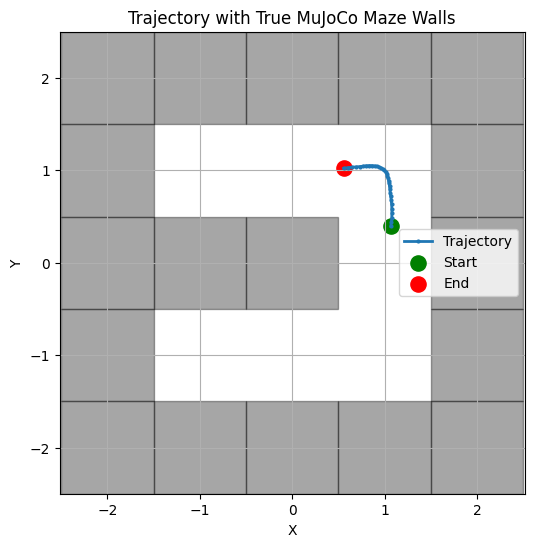

In [6]:
# Sample a trajectory window
idx = random.randint(0, len(dataset) - 1)
traj_norm = dataset[idx]
traj = dataset.denormalize(traj_norm).numpy()
xy = traj[:, :2]           # XY coordinates (i.e., flat outputs)

# Plot the trajectory
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(xy[:, 0], xy[:, 1], marker='o', linewidth=2, markersize=2, label='Trajectory')
ax.scatter(xy[0, 0], xy[0, 1], c='green', s=120, label='Start')
ax.scatter(xy[-1, 0], xy[-1, 1], c='red', s=120, label='End')

# Render MuJoCo walls
for geom_id in range(mj_model.ngeom):

    # Get geom name
    name = mujoco.mj_id2name(mj_model, mujoco.mjtObj.mjOBJ_GEOM, geom_id)

    if name is None or not "block" in name:
        continue

    pos = mj_model.geom_pos[geom_id]     # center (x, y, z)
    size = mj_model.geom_size[geom_id]   # half-extents (hx, hy, hz)

    cx, cy = pos[:2]
    hx, hy = size[:2]

    rect = Rectangle(
        (cx - hx, cy - hy),
        2 * hx,
        2 * hy,
        color="black",
        alpha=0.35,
        zorder=0
    )
    ax.add_patch(rect)

# Final figure styling
ax.set_title("Trajectory with True MuJoCo Maze Walls")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.axis("equal")
ax.grid(True)
ax.legend()
plt.xlim(-2.5, +2.5)
plt.ylim(-2.5, +2.5)

plt.show()

In [9]:
print(traj[0])
print(traj[-1])

[1.06591915 0.39449871 0.88507522 4.78210334]
[ 0.55692841  1.02245092 -4.62865597 -0.6713081 ]


In [8]:

device = "cuda" if torch.cuda.is_available() else "cpu"
state_dim = dataset.state_dim

print(f"Using device: {device}")

# loaded dataset from earlier
print(f"Loaded dataset with {len(dataset)} segments")
print(f"State dimension = {state_dim}")


# build model and diffuser
model = TemporalUNet(
    state_dim,
    hidden_dims=[128, 256, 512]
).to(device)

diffusion = GaussianDiffusion(
    timesteps=100,
    beta_start=0.0001,
    beta_end=0.02
)

# Move diffusion buffers to device
for attr in [
    "betas",
    "alphas",
    "alphas_cumprod",
    "sqrt_alphas_cumprod",
    "sqrt_one_minus_alphas_cumprod"
]:
    setattr(diffusion, attr, getattr(diffusion, attr).to(device))


# load checkpoint
ckpt_path = "diffuser_checkpoint_epoch_25.pt"

# load checkpoint
ckpt_path = "diffuser_checkpoint_epoch_25.pt"
print(f"Loading checkpoint: {ckpt_path}")

ckpt = torch.load(ckpt_path, map_location=device)

ema_sd = ckpt["ema_model"]

# Remove "module." prefix from EMA params
new_sd = {}
for k, v in ema_sd.items():
    if k.startswith("module."):
        new_sd[k[len("module."):]] = v
    # ignore "n_averaged" and anything else

# Load into model
model.load_state_dict(new_sd)
model.eval()

print("EMA checkpoint loaded successfully.")

print("Checkpoint loaded.")

#build planner
planner = DiffuserPlanner(model, diffusion, dataset, device=device)


# get mujoco model walls
# Assumes you already created the env earlier:
env = gym.make("PointMaze_UMaze-v3")

# Use the MuJoCo model directly (Gymnasium API)
for geom_id in range(mj_model.ngeom):
    name = mujoco.mj_id2name(mj_model, mujoco.mjtObj.mjOBJ_GEOM, geom_id)
    if name is None or "block" not in name:
        continue

    pos = mj_model.geom_pos[geom_id]
    size = mj_model.geom_size[geom_id]

    cx, cy = pos[:2]
    hx, hy = size[:2]

    rect = Rectangle(
        (cx - hx, cy - hy),
        2 * hx,
        2 * hy,
        color="black",
        alpha=0.35,
        zorder=0
    )
    ax.add_patch(rect)



#run diffusion inference
"""
obs, _ = env.reset()

if isinstance(obs, dict):
    obs = obs["observation"]
    """


start = np.array([-0.3, -0.9, 0.0, 0.0], dtype=np.float32)   # bottom-left of U-maze
goal  = np.array([0.4, -0.8, 0.0, 0.0], dtype=np.float32)   # top-right goal

#Changed plan so that it takes start and end goal to condition
traj, actions = planner.plan(start, goal)
xy = traj[:, :2]   # XY points for plotting


#plot
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(
    xy[:, 0], xy[:, 1],
    marker="o", linewidth=2, markersize=2,
    label="Planned Trajectory"
)
ax.scatter(xy[0, 0], xy[0, 1], c="green", s=120, label="Start")
ax.scatter(xy[-1, 0], xy[-1, 1], c="red", s=120, label="End")

for geom_id in range(mj_model.ngeom):

    name = mujoco.mj_id2name(mj_model, mujoco.mjtObj.mjOBJ_GEOM, geom_id)
    if name is None or "block" not in name:
        continue

    pos = mj_model.geom_pos[geom_id]     # (x,y,z) center
    size = mj_model.geom_size[geom_id]   # (hx,hy,hz) half extents

    cx, cy = pos[:2]
    hx, hy = size[:2]

    rect = Rectangle(
        (cx - hx, cy - hy),
        2 * hx,
        2 * hy,
        color="black",
        alpha=0.35,
        zorder=0
    )
    ax.add_patch(rect)



ax.set_title("Planned Trajectory - PointMaze")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.axis("equal")
ax.grid(True)
ax.legend()
plt.tight_layout()

plt.show()


Using device: cpu
Loaded dataset with 639438 segments
State dimension = 4


AttributeError: 'GaussianDiffusion' object has no attribute 'sqrt_alphas_cumprod'

In [8]:
# =========================
# 1. Reward function
# =========================
def reward_sine(x):
    # x: (B, T, C)
    xy = x[..., :2]
    target_y = torch.sin(xy[...,0] * 2 * np.pi)
    return -((xy[...,1] - target_y)**2).sum()


def reward_straight_line(x):
    xy = x[..., :2]
    start = xy[:, 0:1, :]       # (B,1,2)
    end   = xy[:, -1:, :]       # (B,1,2)

    T = xy.shape[1]
    t = torch.linspace(0, 1, T, device=x.device)[None, :, None]

    ideal = start + t * (end - start)
    return -((xy - ideal)**2).sum()


# =========================
# 2. Guided p-sample (NO PERMUTES)
# =========================
def p_sample_guided(diff, model, x, t, t_index, reward_fn, guidance_scale):
    """
    x: (B, T, C)
    Model input: (B, T, C)
    Model output: (B, T, C)
    """
    # enable gradient for reward
    x = x.clone().detach().requires_grad_(True)

    # diffusion buffers
    betas_t = diff.betas[t][:, None, None]
    sqrt_one_minus = diff.sqrt_one_minus_alphas_cumprod[t][:, None, None]
    sqrt_recip_alpha = torch.sqrt(1.0 / diff.alphas[t])[:, None, None]

    # model predicts noise in SAME SHAPE (B,T,C)
    pred_noise = model(x, t)

    # DDPM mean update (all in (B,T,C))
    model_mean = sqrt_recip_alpha * (x - betas_t * pred_noise / sqrt_one_minus)

    # reward gradient
    if guidance_scale > 0:
        R = reward_fn(x)                # scalar
        grad = torch.autograd.grad(R, x)[0]
        model_mean = model_mean + guidance_scale * grad

    # final step no noise
    if t_index == 0:
        return model_mean.detach()

    # add noise normally
    noise = torch.randn_like(x)
    return (model_mean + torch.sqrt(betas_t) * noise).detach()


# =========================
# 3. Inpainting loop
# =========================
def guided_inpaint_sample_loop(
    diff,
    model,
    shape,              # (B, T, C)
    device,
    condition_mask,     # (B, T, C)
    condition_value,    # (B, T, C)
    reward_fn,
    guidance_scale
):
    """
    x stays in (B, T, C) the entire time.
    mask & values are also (B, T, C).
    """
    x = torch.randn(shape, device=device)

    for i in reversed(range(diff.timesteps)):
        t = torch.full((shape[0],), i, device=device, dtype=torch.long)

        # guided step (still (B,T,C))
        x = p_sample_guided(
            diff,
            model,
            x,
            t,
            i,
            reward_fn=reward_fn,
            guidance_scale=guidance_scale
        )

        # clamp start & goal
        x = torch.where(condition_mask, condition_value, x)

    return x


In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# ======================================================
# 1. Get a SINGLE start state (do NOT reset again)
# ======================================================
env = gym.make("PointMaze_UMaze-v3")

start = np.array([-0.3, -0.9, 0.0, 0.0], dtype=np.float32)   # bottom-left of U-maze
goal  = np.array([0.4, -0.8, 0.0, 0.0], dtype=np.float32)   # top-right goal

start_norm = (start - dataset.mean) / dataset.std
goal_norm  = (goal  - dataset.mean) / dataset.std

start_norm = torch.tensor(start_norm, dtype=torch.float32, device=device)
goal_norm  = torch.tensor(goal_norm,  dtype=torch.float32, device=device)

# ======================================================
# 3. Build conditioning mask and values
# ======================================================
horizon = 32
shape = (1, horizon, dataset.state_dim)

condition_mask  = torch.zeros(shape, dtype=torch.bool,   device=device)
condition_value = torch.zeros(shape, dtype=torch.float32, device=device)

# clamp first frame to START
condition_mask[0, 0, :] = True
condition_value[0, 0, :] = start_norm

# clamp last frame to GOAL
condition_mask[0, -1, :] = True
condition_value[0, -1, :] = goal_norm



# ======================================================
# 4. Run reward-guided inpainting diffusion
# ======================================================
guidance_scale = 0.000   # try 0.0 → 0.005

traj_tensor = guided_inpaint_sample_loop(
    diffusion,
    model,
    shape,
    device,
    condition_mask,
    condition_value,
    reward_fn=reward_sine,
    guidance_scale=guidance_scale,
)


# ======================================================
# 5. Denormalize trajectory
# ======================================================
traj = traj_tensor[0].detach().cpu().numpy()
traj = dataset.denormalize(traj)
xy = traj[:, :2]


# ======================================================
# 6. Plot trajectory + maze walls
# ======================================================
fig, ax = plt.subplots(figsize=(6, 6))

# Draw trajectory
ax.plot(
    xy[:,0], xy[:,1],
    marker="o", markersize=4, linewidth=2,
    label="Reward-Guided Trajectory"
)
ax.scatter(xy[0,0], xy[0,1], c="green", s=140, label="Start (fixed)")
ax.scatter(xy[-1,0], xy[-1,1], c="red", s=140, label="Goal (fixed)")

# Draw walls from mujoco
for geom_id in range(mj_model.ngeom):
    name = mujoco.mj_id2name(mj_model, mujoco.mjtObj.mjOBJ_GEOM, geom_id)
    if name is None or "block" not in name:
        continue

    pos = mj_model.geom_pos[geom_id]
    size = mj_model.geom_size[geom_id]

    cx, cy = pos[:2]
    hx, hy = size[:2]

    rect = Rectangle(
        (cx - hx, cy - hy),
        2 * hx,
        2 * hy,
        color="gray",
        alpha=0.35,
        zorder=0
    )
    ax.add_patch(rect)

ax.set_title(f"Reward-Guided Diffusion (guidance={guidance_scale})")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.axis("equal")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


NameError: name 'device' is not defined

norm start target : [-0.29751354  0.14790738  0.00826468 -0.00119391]
norm start actual : [-0.29751354  0.14790738  0.00826468 -0.00119391]
norm goal target  : [ 0.7157948   1.0566808   0.00826468 -0.00119391]
norm goal actual  : [ 0.7157948   1.0566808   0.00826468 -0.00119391]


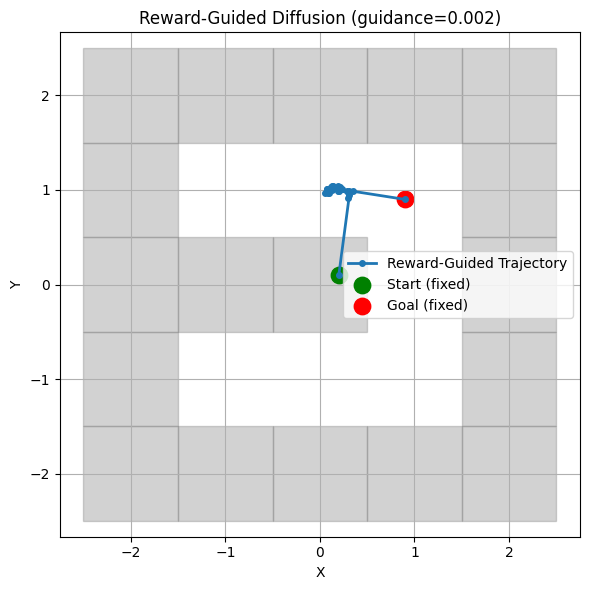

In [ ]:
#start and goal clamp (no reward)
import torch

@torch.no_grad()
def sample_with_fixed_start_and_goal(
    diffusion,
    model,
    start_state,
    goal_state,
    dataset,
    horizon=32,
    device="cuda"
):
    """
    Force:
        x[0]     = start_state
        x[T - 1] = goal_state
    in *normalized* space, then denormalize at the end.
    """
    # ---- normalize start & goal ----
    start_norm = (start_state - dataset.mean) / dataset.std
    goal_norm  = (goal_state  - dataset.mean) / dataset.std

    start_norm = torch.tensor(start_norm, dtype=torch.float32, device=device)
    goal_norm  = torch.tensor(goal_norm,  dtype=torch.float32, device=device)

    B = 1
    T = horizon
    C = dataset.state_dim
    shape = (B, T, C)

    # ---- build mask/value (B, T, C) ----
    condition_mask  = torch.zeros(shape, dtype=torch.bool,   device=device)
    condition_value = torch.zeros(shape, dtype=torch.float32, device=device)

    condition_mask[0, 0, :]  = True
    condition_value[0, 0, :] = start_norm

    condition_mask[0, -1, :]  = True
    condition_value[0, -1, :] = goal_norm

    # ---- reverse diffusion, with clamping every step ----
    x = torch.randn(shape, device=device)

    for i in reversed(range(diffusion.timesteps)):
        t = torch.full((B,), i, device=device, dtype=torch.long)
        x = diffusion.p_sample(model, x, t, i)  # model expects (B, T, C)
        x = torch.where(condition_mask, condition_value, x)

    # ---- debug: check clamping in *normalized* space ----
    print("norm start target :", start_norm.detach().cpu().numpy())
    print("norm start actual :", x[0, 0].detach().cpu().numpy())
    print("norm goal target  :", goal_norm.detach().cpu().numpy())
    print("norm goal actual  :", x[0, -1].detach().cpu().numpy())

    assert torch.allclose(x[0, 0],  start_norm, atol=1e-5), "start not clamped!"
    assert torch.allclose(x[0, -1], goal_norm,  atol=1e-5), "goal not clamped!"

    # ---- denormalize and return (T, C) numpy ----
    traj_norm = x[0].detach().cpu().numpy()
    traj = dataset.denormalize(traj_norm)
    return traj


obs, _ = env.reset()
if isinstance(obs, dict):
    obs = obs["observation"]

start = np.array([0.2, 0.1, 0.0, 0.0], dtype=np.float32)
goal  = np.array([0.9, 0.9, 0.0, 0.0], dtype=np.float32)

traj = sample_with_fixed_start_and_goal(
    diffusion,
    model,
    start_state=start,
    goal_state=goal,
    dataset=dataset,
    horizon=32,
    device=device,
)

xy = traj[:, :2]


# ======================================================
# 6. Plot trajectory + maze walls
# ======================================================
fig, ax = plt.subplots(figsize=(6, 6))

# Draw trajectory
ax.plot(
    xy[:,0], xy[:,1],
    marker="o", markersize=4, linewidth=2,
    label="Reward-Guided Trajectory"
)
ax.scatter(xy[0,0], xy[0,1], c="green", s=140, label="Start (fixed)")
ax.scatter(xy[-1,0], xy[-1,1], c="red", s=140, label="Goal (fixed)")

# Draw walls from mujoco
for geom_id in range(mj_model.ngeom):
    name = mujoco.mj_id2name(mj_model, mujoco.mjtObj.mjOBJ_GEOM, geom_id)
    if name is None or "block" not in name:
        continue

    pos = mj_model.geom_pos[geom_id]
    size = mj_model.geom_size[geom_id]

    cx, cy = pos[:2]
    hx, hy = size[:2]

    rect = Rectangle(
        (cx - hx, cy - hy),
        2 * hx,
        2 * hy,
        color="gray",
        alpha=0.35,
        zorder=0
    )
    ax.add_patch(rect)

ax.set_title(f"Reward-Guided Diffusion (guidance={guidance_scale})")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.axis("equal")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

